# Download Data
1. Download the pickled gzip file from google drive.
2. Check the filehash
3. Unpickle and read
4. Check that there are `5051` total books

In [1]:
import pickle
import gzip
import gdown
import hashlib

import math
import time
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch import optim

from functools import partial

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
!pip install -q transformers
!pip install -q pytictoc
from transformers import get_linear_schedule_with_warmup
from pytictoc import TicToc

In [3]:
# Download from public url in google drive:
# https://drive.google.com/file/d/1MzHuNU0RzjYILE1-dnsejpn6rLtX27b1/view?usp=sharing

! gdown 1MzHuNU0RzjYILE1-dnsejpn6rLtX27b1

Downloading...
From: https://drive.google.com/uc?id=1MzHuNU0RzjYILE1-dnsejpn6rLtX27b1
To: /content/FULL.gz
100% 1.34G/1.34G [00:04<00:00, 287MB/s]


In [4]:
# Check file-hash to verify download
with open('FULL.gz', 'rb') as file:
  print("Reading gzip file...")
  contents = file.read()

print("Checking file-hash...")
hashobj = hashlib.sha256(contents)
correct = "33cc853c499d08b841be17517472b0ffb703235d8239c198f5d5ad5160a5a11f"

print(f"sha256: {hashobj.hexdigest()}")
print(f"Hash matches: {str(str(hashobj.hexdigest()) == correct).upper()}")

Reading gzip file...
Checking file-hash...
sha256: 33cc853c499d08b841be17517472b0ffb703235d8239c198f5d5ad5160a5a11f
Hash matches: TRUE


In [5]:
# Read/Expand the data
import random
print("Opening file...")
with gzip.open('FULL.gz', 'rb') as file:
  print("Expanding file...")
  all_books = pickle.load(file)

  # Only use a random subset of all the books
  random.shuffle(all_books)

print("DONE!")

Opening file...
Expanding file...
DONE!


In [6]:
print(f"Total number of books: {len(all_books)}")
print(f"      Have all books?: {len(all_books) == 5051}")

Total number of books: 5051
      Have all books?: True


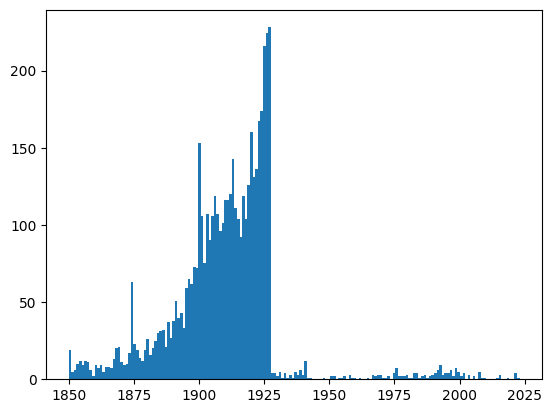

In [7]:
all_years = [b['year'] for b in all_books]
plt.hist(all_years, bins=max(all_years)-min(all_years)+1)
plt.show()

total num of books: 1,815


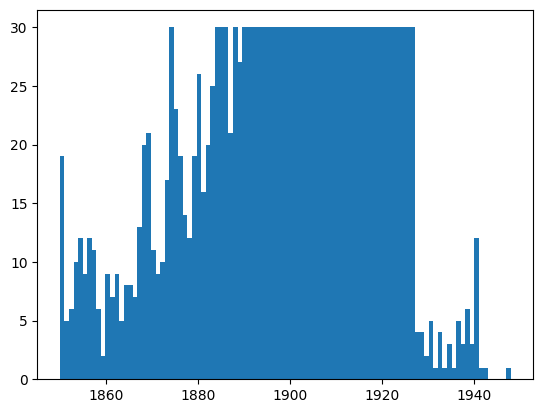

In [8]:
# Cap books by year and reduce down to 1850-1950
subsetbooks = []
counts = {}
CAP = 30
subsetyears = []
for book in all_books:
  y = book['year']
  if counts.get(y, 0) >= CAP or y > 1950:
    continue
  else:
    subsetbooks.append(book)
    subsetyears.append(y)
    counts[y] = counts.get(y, 0)+1

books = subsetbooks
print(f'total num of books: {len(books):,}')
plt.hist(subsetyears, bins=max(subsetyears)-min(subsetyears)+1)
plt.show()

In [9]:
# Reduce number of books and attempt normal distribution of years
all_years = []
for book in books:
  all_years.append(book['year'])

GLOBAL_MIN_YEAR = min(all_years)
GLOBAL_MAX_YEAR = max(all_years)
GLOBAL_YEAR_RANGE = GLOBAL_MAX_YEAR - GLOBAL_MIN_YEAR + 1

print(GLOBAL_MIN_YEAR, GLOBAL_MAX_YEAR)
print(GLOBAL_YEAR_RANGE)

1850 1948
99


## Quick data demo
Each item in the `books` list has keys:
- `identifier`: The arbitrary id assigned by The Internet Archive for the book (useful if you want to find the original book as a pdf on IA).
- `creator`: The author or publisher of the book.
- `year`: Year of writing (according to IA). This should be our target attribute.
- `title`: The full title of the book.
- `text`: The full plain-text of the book, straight from the `.txt` files found on IA.
  - NOTE: We will probably want to make sure to ignore the first few pages of tokens in the texts because most have the page with the date of publication, which would just be cheating.
  - Also there's been no cleaning in regards to language or special characters.

In [10]:
# Show info available on a random book (the first one in the set)
b = books[0]
for key, val in b.items():
  if key != 'text':
    print(f"{key:>10} | {val}")
  else:
    short = val[200:300].replace('\n', ' ').strip()
    print(f"{key:>10} | {short}")

identifier | apocryphatransla0000unse_c2i5
      year | 1914
     title | The Apocrypha : translated out of the Greek and Latin tongues ; being the version set fourth A.D. 1611, compared with the most ancient authorities and revised A.D. 1894
      text | , aad be    4    ; abe    7 oe            i  * a \  a) ; ¢  ter " it Se a .  ¢ ¥ , . F  . s he 4


# Creating Dataloader
Current dataset just has plain text, no cleaning at all.

The first few pages of most books will have publication year, we will need to be sure that we are removing these first few pages before passing text into the model.

We also should try to split the data down to paragraphs to avoid passing in full books which would be excessive.

In [11]:
# Parse Books to make paragraphs

total_words = 0
ids = []
years = []
texts = []

max_words = 0
max_text = None

for book in tqdm(books):
  # Filter for longer paragraphs and exclude first pages
  for i, para in enumerate(book['text'].strip().split('\n\n')):
    if (len(para) < 200 or len(para) > 3_000) or (i <= 10):
      continue
      
    num_words = len(para.strip().split(' '))
    total_words += num_words
    if num_words > max_words:
      max_words = num_words
      max_text = para


    ids.append(book['identifier'])
    years.append(book['year'])
    texts.append(para.strip())

para_df = pd.DataFrame({
    'ids': ids,
    'year': years,
    'text': texts,
})

print(f'       Total paras: {len(texts):,}')
print(f'Total num of words: {total_words:,}')
print(f'    Average length: {total_words / len(texts):.1f}\n')
print(para_df)

print(f'BUILDING PARAGRAPH LIST...')
para_df_list = list(para_df.iterrows())

  0%|          | 0/1815 [00:00<?, ?it/s]

       Total paras: 1,797,845
Total num of words: 224,245,765
    Average length: 124.7

                                   ids  year  \
0        apocryphatransla0000unse_c2i5  1914   
1        apocryphatransla0000unse_c2i5  1914   
2        apocryphatransla0000unse_c2i5  1914   
3        apocryphatransla0000unse_c2i5  1914   
4        apocryphatransla0000unse_c2i5  1914   
...                                ...   ...   
1797840       jahrbucherfurpro0002unse  1875   
1797841       jahrbucherfurpro0002unse  1875   
1797842       jahrbucherfurpro0002unse  1875   
1797843       jahrbucherfurpro0002unse  1875   
1797844       jahrbucherfurpro0002unse  1875   

                                                      text  
0        The present work, owing to various circumstanc...  
1        The Revision of the Authorised Version of the ...  
2        It was resolved (March 21, 1879) that, after t...  
3        The London Committee was to consist of the fol...  
4        The Westminster Comm

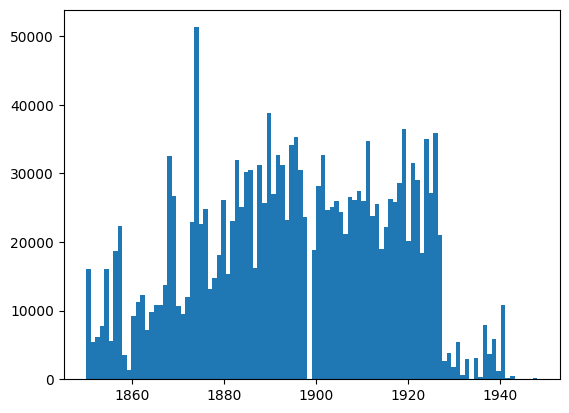

In [12]:
# Get year distribution BEFORE subselection
plt.hist(para_df.year, bins=GLOBAL_YEAR_RANGE+1)
plt.show()

In [13]:
# TOTAL_PARA = 3_200
TOTAL_PARA = 2_200
# TOTAL_PARA = 1_200
allotment = (TOTAL_PARA // GLOBAL_YEAR_RANGE) + 0
print(f'Allotment is: {allotment}')
CUTOFF = len(para_df) // 5
print(f'CUTOFF: {CUTOFF}')
print(f'Total number of available para: {len(para_df_list)}')

used = []
counts = {}
# for i, (idx, row) in tqdm(enumerate(random.sample(para_df_list, CUTOFF))):
for i, (idx, row) in tqdm(enumerate(random.sample(para_df_list, len(para_df_list)))):
  if i >= len(para_df_list)-1:
    print(f'CHECKED ALL PARAS')

  y = row.year
  currcount = counts.get(y, 0)
  if currcount >= allotment:
    continue
  else:
    counts[y] = currcount + 1
    used.append(idx)
  
  if len(used) >= TOTAL_PARA:
    print(f'BREAKING because total used: {len(used)} is more than TOTAL_PARA: {TOTAL_PARA}')
    break
  


print(used)
subset = para_df.iloc[used]
print(subset)
print(len(subset))


Allotment is: 22
CUTOFF: 359569
Total number of available para: 1797845


0it [00:00, ?it/s]

CHECKED ALL PARAS
[436266, 463624, 1749883, 1496059, 589264, 1137727, 974481, 620776, 1718188, 72325, 208905, 400618, 1528618, 289330, 482067, 587597, 497157, 923836, 467313, 627712, 1783891, 95643, 723107, 1779550, 1184351, 333430, 508709, 439101, 717874, 461309, 1171450, 896821, 454247, 378011, 1439831, 374290, 712162, 1628307, 184713, 1029570, 1299849, 503122, 667269, 826398, 279980, 1612251, 1880, 795759, 602707, 1182024, 995186, 95034, 751503, 399876, 1326030, 1142800, 952421, 555268, 1533578, 561662, 1779246, 893294, 658062, 290372, 607900, 1708335, 1451354, 1558645, 409426, 517590, 1161280, 341447, 1296776, 892266, 60871, 361208, 1121260, 1737445, 1036240, 152242, 1138026, 103948, 708615, 383606, 1611128, 1597777, 620634, 1207413, 1151691, 1726978, 1443652, 966453, 366423, 252433, 783613, 516941, 1673546, 1719242, 1759538, 95151, 1547028, 1387374, 226054, 899754, 1509373, 306047, 78046, 864499, 1718225, 1750163, 1382847, 146222, 1769617, 1786810, 1054826, 1032808, 491664, 126662

1897.042105263158
27.497718867867714


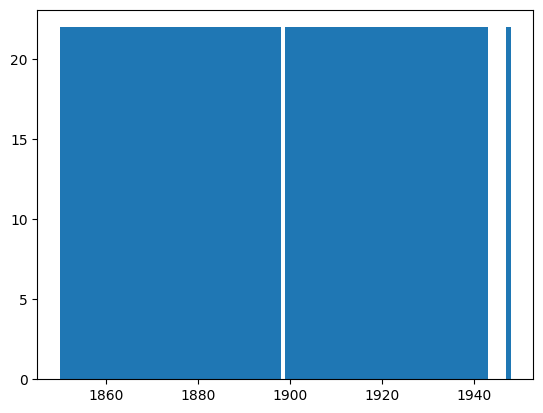

In [14]:
# print(subset.year)
# for year in range(GLOBAL_MIN_YEAR, GLOBAL_MAX_YEAR+1):
#   print(year, counts.get(year, 0))
print(np.mean(subset.year))
print(np.std(subset.year))
plt.hist(subset.year, bins=GLOBAL_YEAR_RANGE+1)
plt.show()

In [15]:
# Build a dataframe to back a dataset
class df_dataset(Dataset):
  def __init__(self, paradf):
    self.df = paradf

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    return self.df.iloc[idx]

In [16]:
# used_para = para_df[:1_000]
used_para = subset
train_stop = int(len(used_para) * 0.8)
val_stop = int(len(used_para) * 0.1)
test_stop = int(len(used_para) * 0.1)
train_books = used_para[:train_stop]
val_books = used_para[train_stop:(train_stop+val_stop)]
test_books = used_para[(train_stop+val_stop):]

train_dataset = df_dataset(train_books)
val_dataset = df_dataset(val_books)
test_dataset = df_dataset(test_books)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1672
209
209


## Check data distribution on training data

**NOTE:** Our data is super skewed

**TODO:** Instead of blindly filtering out out books by the first 1,000 should probably iteratively build a collection with an even distribution.

1892.8791866028707
23.412153783728026


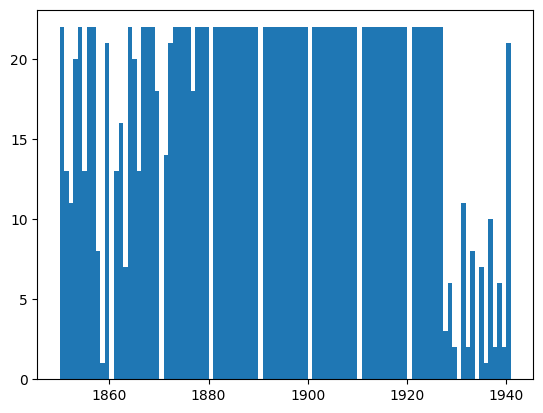

In [17]:
print(np.mean(train_books.year))
print(np.std(train_books.year))
plt.hist(train_books['year'], bins=GLOBAL_YEAR_RANGE+1)
plt.show()

# Helper Functions
- Collate functions. A few different options:
  - Targets as vectors with normal distribution around correct year
  - Targets as one-hot vectors (where correct year is a 1)
  - Targets as single float value (ex: 1920.0)
- Main Functions:
  - Train
  - Evaluate Loss
  - Evaluate Accuracy

In [18]:
# Define collate func

def discrete_collate(batch, tokenizer, std_dev=5):
  '''
  Targets as vectors with normal distribution around the correct year.
  Size of vector corresponds to the range of years in the full data.
  '''
  texts, labels, masks = [], [], []
  for data in batch:
    tokenizer_output = tokenizer([data['text']], truncation=True)
    tokenized_para = tokenizer_output['input_ids'][0]
    texts.append(torch.tensor(tokenized_para))

    masks.append(torch.tensor(tokenizer_output['attention_mask'][0]))

    # Convert integer years to a normal distribution that centers around the year
    skewed = (torch.tensor(data['year']) - GLOBAL_MIN_YEAR)
    normal = torch.distributions.normal.Normal(skewed, std_dev)
    values = torch.exp(normal.log_prob(torch.linspace(0, GLOBAL_YEAR_RANGE-1, GLOBAL_YEAR_RANGE)))
    labels.append(values)

    # print(f'\nOriginal: {data["year"]}')
    # print(f'skewed: {skewed}')
    # print(f'center: {torch.argmax(values)}')

    # X = torch.arange(GLOBAL_YEAR_RANGE)
    # plt.scatter(X, values)
    # plt.scatter(skewed, values[skewed], color='red')
    # plt.axvline(skewed)
    # plt.show()

  texts = pad_sequence(texts, batch_first=True).to(device)
  labels = torch.stack(labels, dim=0).to(device)
  masks = pad_sequence(masks, batch_first=True, padding_value=0.0).to(device)

  return texts, labels, masks

def discrete_one_hot_collate(batch, tokenizer):
  '''
  Collate and make target labels as a one-hot vector.
  Values will be 0 for all years, and 1 for year of text.
  '''
  # NOTE: This might be worth using to show some example data for how much worse this is than non-binary targets
  texts, labels, masks = [], [], []
  for data in batch:
    tokenizer_output = tokenizer(data['text'], truncation=True)
    tokenized_para = tokenizer_output['input_ids'][0]
    texts.append(torch.tensor(tokenized_para))

    mask = tokenizer_output['attention_mask'][0]
    masks.append(torch.tensor(mask))

    skewed = (torch.tensor(data['year'])- GLOBAL_MIN_YEAR)

    one_hot = F.one_hot(skewed, num_classes=GLOBAL_YEAR_RANGE).float()
    year_tens = torch.tensor(data['year']) - GLOBAL_MIN_YEAR
    one_hot = F.one_hot(year_tens, num_classes=GLOBAL_YEAR_RANGE).float()
    labels.append(one_hot)
  
  texts = pad_sequence(texts, batch_first=True).to(device)
  labels = torch.stack(labels, dim=0).to(device)
  masks = pad_sequence(masks, batch_first=True, padding_value=0.0).to(device)

  return texts, labels, masks
    

def continuous_collate(batch, tokenizer):
  texts, labels, masks = [], [], []
  real_years = []
  for data in batch:
    tokenizer_output = tokenizer([data['text']], truncation=True)
    tokenized_para = tokenizer_output['input_ids'][0]
    texts.append(torch.tensor(tokenized_para))

    mask = tokenizer_output['attention_mask'][0]
    masks.append(torch.tensor(mask))

    years = torch.tensor(data['year']).unsqueeze(0).float()
    normal_years = (years - GLOBAL_MIN_YEAR) / GLOBAL_YEAR_RANGE
    # normal_years = (years - GLOBAL_MIN_YEAR)
    labels.append(normal_years)
    real_years.append(years)

  texts = pad_sequence(texts, batch_first=True).to(device)
  labels = torch.stack(labels, dim=0).to(device)
  masks = pad_sequence(masks, batch_first=True, padding_value=0.0).to(device)
  real_years = torch.stack(real_years, dim=0).to(device)

  return texts, labels, masks, real_years

In [19]:
def train(model, dataloader, optimizer, criterion, device, clip, scheduler=None):
  model.train()
  epoch_loss = 0
  for batch in tqdm(dataloader):
    optimizer.zero_grad()

    texts, labels, masks = batch[0], batch[1], batch[2]
    output = model(texts.to(device), masks.to(device))

    loss = criterion(output, labels.to(device))

    lambda1 = 0.4
    lambda2 = 0.1
    # l1_params = torch.cat([x.view(-1) for x in model.linear_map.parameters()])
    # l1_reg = lambda1 * torch.norm(l1_params, p=1)
    # l2_reg = lambda2 * torch.norm(l1_params, p=2)
    # loss += l1_reg + l2_reg
    # loss += l1_reg

    # print(f'Got loss: {loss}')
    # print(f'output: {output}')
    # print(f'labels: {labels}')
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()
    if scheduler is not None:
      scheduler.step()
    
    epoch_loss += loss.item()

  return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
  model.eval()

  epoch_loss = 0
  with torch.no_grad():
    for batch in tqdm(dataloader):
      texts, labels, masks = batch[0], batch[1], batch[2]

      output = model(texts.to(device), masks.to(device))
      loss = criterion(output, labels.to(device))
      lambda1 = 0.4
      lambda2 = 0.1
      # l1_params = torch.cat([x.view(-1) for x in model.linear_map.parameters()])
      # l1_reg = lambda1 * torch.norm(l1_params, p=1)
      # l2_reg = lambda2 * torch.norm(l1_params, p=2)
      # loss += l1_reg + l2_reg
      # loss += l1_reg
      epoch_loss += loss.item()

  return epoch_loss / len(dataloader)

def evaluate_acc(model, dataloader, device):
  model.eval()

  epoch_loss = 0
  with torch.no_grad():
    total_correct = 0
    total = 0
    for batch in tqdm(dataloader):
      texts, labels, masks = batch[0], batch[1], batch[2]
      labels_class = torch.argmax(labels, dim=1)

      output = model(texts.to(device), masks.to(device))
      output = F.softmax(output, dim=1)
      output_class = torch.argmax(output, dim=1)
      
      total_correct += torch.sum(torch.where(output_class == labels_class.to(device), 1, 0))
      total += texts.size()[0]
  
  return total_correct / total

def evaluate_dist(model, dataloader, device):
  '''
  Evaluate based off of average distance from correct year
  '''
  model.eval()

  total_dist = 0
  total = 0
  with torch.no_grad():
    
    for batch in tqdm(dataloader):
      texts, labels, masks = batch
      correct = torch.argmax(labels, dim=1)

      output = model(texts.to(device), masks.to(device))
      output = F.softmax(output, dim=1)
      output_class = torch.argmax(output, dim=1)

      dists = torch.abs(correct - output_class)
      total_dist += dists.sum()
      total += dists.size()[0]
  
  return total_dist / total

def continuous_acc(model, dataloader, device):
  model.eval()

  epoch_loss = 0
  with torch.no_grad():
    total_correct = 0
    total = 0
    for batch in tqdm(dataloader):
      texts, labels, masks, real = batch

      output = model(texts.to(device), masks.to(device))
      # Rescale output back to specific years and count matches
      output = torch.round((output * GLOBAL_YEAR_RANGE) + GLOBAL_MIN_YEAR)

      counts = torch.where(output == real, 1, 0)
      total_correct += torch.sum(counts)
      total += len(output)

  return total_correct / total


def continuous_dist(model, dataloader, device):
  model.eval()

  total_dist = 0
  total = 0
  with torch.no_grad():
    for batch in tqdm(dataloader):
      texts, labels, masks, real = batch

      # Rescale output back to specific years and compare
      output = model(texts.to(device), masks.to(device))
      output = torch.round((output * GLOBAL_YEAR_RANGE) + GLOBAL_MIN_YEAR)
      dists = torch.abs(real - output)
      total_dist += dists.sum()
      total += dists.size()[0]

  return total_dist / total

In [20]:
def init_weights(m: nn.Module, hidden_size=768):
    k = 1/hidden_size
    for name, param in m.named_parameters():
        if 'weight' in name:
            print(name)
            nn.init.uniform_(param.data, a=-1*k**0.5, b=k**0.5)
        else:
            print(name)
            nn.init.uniform_(param.data, 0)

def init_classification_head_weights(m: nn.Module, hidden_size=768):
    ### YOUR CODE STARTS HERE ###
    k = 1 / hidden_size
    for name, param in m.named_parameters():
        if 'classifier' in name:
            if 'weight' in name:
                print(name)
                nn.init.uniform_(param.data, a=-1*k**0.5, b=k**0.5)
            else:
                print(name)
                nn.init.uniform_(param.data, 0)

def count_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def total_params(model):
  return sum(p.numel() for p in model.parameters())

# Defining Model(s)

We should probably just use existing open source models (BERT, GPT-2?) for getting embedding's.

We will have to train our own model(s) to transform embeddings to year-label predictions.
**NOTE:** I'm not sure what the most reasonable output for this would be. A full one-hot matrix for the full year range (~1850-2023)? Or maybe some continuous output that is mapped to a year? I would imagine that label probabilities would look close to a normal distribution (i.e. wouldn't expect a text to be 1920 OR 2020, probable just something like 1920-1923).

In [21]:
from transformers import AutoModel, AutoTokenizer, IBertModel, AutoConfig
model_name = 'distilbert-base-uncased'
config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
distilbert_model = AutoModel.from_pretrained(model_name, config=config)
distilbert_continuous = AutoModel.from_pretrained(model_name, config=config)
distil_tokenizer = AutoTokenizer.from_pretrained(model_name)

ibert_model_name = 'kssteven/ibert-roberta-base'
ibert_config = AutoConfig.from_pretrained(ibert_model_name, output_hidden_states=True)
ibert_tokenizer = AutoTokenizer.from_pretrained(ibert_model_name)
ibert_submodel = IBertModel.from_pretrained(ibert_model_name, config=ibert_config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- T

In [22]:
# Define model
import torch.nn as nn
class DiscreteModel(nn.Module):
  def __init__(self, submodel, enc_hid_dim=768, dropout=0.1, flatten_all=False, n_layers=7):
    super().__init__()

    self.flatten_all = flatten_all
    self.submodel = submodel
    self.enc_hid_dim = enc_hid_dim if not flatten_all else (enc_hid_dim * n_layers)
    self.n_layers = n_layers

    for param in self.submodel.parameters():
      param.requires_grad = False

    self.dropout = nn.Dropout(dropout)
    # Single layer approach
    self.linear_map = nn.Linear(self.enc_hid_dim, GLOBAL_YEAR_RANGE)

    # Two layer approach
    # self.intermediate = nn.Linear(self.enc_hid_dim, GLOBAL_YEAR_RANGE*2)
    # self.linear_map = nn.Linear(GLOBAL_YEAR_RANGE*2, GLOBAL_YEAR_RANGE)

    self.soft = nn.Softmax(dim=1)
  
  def forward(self, src, mask):
    submodel_out = self.submodel(src, mask, output_hidden_states=True)

    if self.flatten_all:
      sub_vect = torch.cat(submodel_out.hidden_states[-self.n_layers:], dim=2)[:, 0]
    else:
      # With only last hidden state
      sub_vect = submodel_out.last_hidden_state[:, 0]

    sub_vect = self.dropout(sub_vect)

    # For two layer approach
    # sub_vect = self.intermediate(sub_vect)

    logits = self.linear_map(sub_vect)
    logits = self.soft(logits)

    return logits

class ContinuousModel(nn.Module):
  def __init__(self, submodel, enc_hid_dim=768, hid_dim=100, dropout=0.1):
    super().__init__()

    self.submodel = submodel
    self.enc_hid_dim = enc_hid_dim
    self.hid_dim = hid_dim

    for param in self.submodel.parameters():
      param.requires_grad = False

    self.dropout = nn.Dropout(dropout)

    # Two layer approach
    # self.intermediate = nn.Linear(enc_hid_dim, self.hid_dim)
    # self.linear_map = nn.Linear(self.hid_dim, 1)

    # Single layer approach
    self.linear_map = nn.Linear(enc_hid_dim, 1)
  
  def forward(self, src, mask):
    submodel_out = self.submodel(src, mask)
    sub_vect = submodel_out.last_hidden_state[:, 0]
    sub_vect = self.dropout(sub_vect)

    # For two layer approach
    # sub_vect = self.intermediate(sub_vect)

    pred = self.linear_map(sub_vect)

    return pred

In [23]:
# Make instance of model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'USING DEVICE: {str(device).upper()}')

USING DEVICE: CUDA


# Model Training

## Distrete Classification Model

In [41]:
# model = DiscreteModel(distilbert_model, dropout=0.1, flatten_all=True, n_layers=3).to(device)
# model = DiscreteModel(distilbert_model, dropout=0.15, flatten_all=False).to(device)
model = DiscreteModel(distilbert_model, dropout=0.2, flatten_all=False).to(device)
model.apply(init_classification_head_weights)
model.to(device)
print(f'Total trainable params: {count_params(model):,}')
print(f'          Total params: {total_params(model):,}')
print('Model initialized\n')


Total trainable params: 76,131
          Total params: 66,439,011
Model initialized



In [42]:
BATCH_SIZE = 10
LR = 1e-3
N_EPOCHS = 10
CLIP = 1.0
WEIGHT_DECAY = 0

In [43]:
train_dataloader = DataLoader(
  train_dataset,
  batch_size=BATCH_SIZE,
  collate_fn=partial(discrete_collate, tokenizer=distil_tokenizer),
  shuffle=True
)
val_dataloader = DataLoader(
  val_dataset,
  batch_size=BATCH_SIZE,
  collate_fn=partial(discrete_collate, tokenizer=distil_tokenizer)
)
test_dataloader = DataLoader(
  test_dataset,
  batch_size=BATCH_SIZE,
  collate_fn=partial(discrete_collate, tokenizer=distil_tokenizer)
)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=N_EPOCHS*len(train_dataloader))
class_criterion = nn.MSELoss()
# class_criterion = nn.CrossEntropyLoss()

In [44]:
# Set model to fine-tune distil-bert
# for param in model.parameters():
#   param.requires_grad = True

print(f'The model has {count_params(model):,} trainable parameters')
print(f'Total num of params: {total_params(model):,}')
print(model.enc_hid_dim)
print(model)

The model has 76,131 trainable parameters
Total num of params: 66,439,011
768
DiscreteModel(
  (submodel): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(


In [45]:
train_loss = evaluate(model, train_dataloader, class_criterion, device)
train_error = evaluate_dist(model, train_dataloader, device)

valid_loss = evaluate(model, val_dataloader, class_criterion, device)
valid_error = evaluate_dist(model, val_dataloader, device)

print(f'Initial Train Loss: {train_loss:.5f}')
print(f'Initial Train Error Margin (years): {train_error:.3f}')
print(f'Initial Valid Loss: {valid_loss:.5f}')
print(f'Initial Valid Error Margin (years): {valid_error:.3f}')

train_losses = []
train_errors = []
valid_losses = []
valid_errors = []
for epoch in range(N_EPOCHS):

  # Training
  start_time = time.time()
  train_loss = train(model, train_dataloader, optimizer, class_criterion, device, CLIP, scheduler)
  # train_loss = train(model, train_dataloader, optimizer, class_criterion, device, CLIP)
  end_time = time.time()
  train_error = evaluate_dist(model, train_dataloader, device)

  # Validation
  valid_loss = evaluate(model, val_dataloader, class_criterion, device)
  valid_error = evaluate_dist(model, val_dataloader, device)

  # Track values
  train_losses.append(train_loss)
  train_errors.append(train_error.item())
  valid_losses.append(valid_loss)
  valid_errors.append(valid_error.item())

  # Print info
  epoch_secs = end_time - start_time
  print(f'Epoch: {epoch+1:02} / {N_EPOCHS} | Time: {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.5f}')
  print(f'\tTrain Error Margin: {train_error:.3f}')
  print(f'\tValid Loss: {valid_loss:.5f}')
  print(f'\tValid Error Margin: {valid_error:.3f}')

test_loss = evaluate(model, test_dataloader, class_criterion, device)
test_error = evaluate_dist(model, test_dataloader, device)
print(f'TESTING:')
print(f'\t    Testing Loss: {test_loss:.5f}')
print(f'\tTesting Error Margin: {test_error:.3f}')

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Initial Train Loss: 0.00047
Initial Train Error Margin (years): 26.080
Initial Valid Loss: 0.00048
Initial Valid Error Margin (years): 37.789


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 01 / 10 | Time: 21.10928249359131s
	Train Loss: 0.00044
	Train Error Margin: 16.650
	Valid Loss: 0.00050
	Valid Error Margin: 26.263


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 02 / 10 | Time: 20.75991702079773s
	Train Loss: 0.00042
	Train Error Margin: 16.186
	Valid Loss: 0.00052
	Valid Error Margin: 27.053


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 03 / 10 | Time: 21.04240322113037s
	Train Loss: 0.00041
	Train Error Margin: 16.146
	Valid Loss: 0.00049
	Valid Error Margin: 26.636


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 04 / 10 | Time: 20.791017055511475s
	Train Loss: 0.00041
	Train Error Margin: 15.994
	Valid Loss: 0.00048
	Valid Error Margin: 23.766


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 05 / 10 | Time: 20.745238780975342s
	Train Loss: 0.00040
	Train Error Margin: 15.990
	Valid Loss: 0.00047
	Valid Error Margin: 22.187


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 06 / 10 | Time: 20.75317621231079s
	Train Loss: 0.00040
	Train Error Margin: 15.267
	Valid Loss: 0.00047
	Valid Error Margin: 23.297


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 07 / 10 | Time: 20.62689518928528s
	Train Loss: 0.00039
	Train Error Margin: 15.217
	Valid Loss: 0.00048
	Valid Error Margin: 22.789


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 08 / 10 | Time: 20.302544832229614s
	Train Loss: 0.00039
	Train Error Margin: 15.395
	Valid Loss: 0.00047
	Valid Error Margin: 22.062


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 09 / 10 | Time: 20.57172155380249s
	Train Loss: 0.00039
	Train Error Margin: 15.008
	Valid Loss: 0.00048
	Valid Error Margin: 23.569


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10 / 10 | Time: 20.8786883354187s
	Train Loss: 0.00039
	Train Error Margin: 14.989
	Valid Loss: 0.00048
	Valid Error Margin: 23.349


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

TESTING:
	    Testing Loss: 0.00053
	Testing Error Margin: 32.684


train loss: [0.0004414083249728373, 0.0004228181756583841, 0.0004137140191839232, 0.000406209964109751, 0.000401920549761382, 0.00039754845645456084, 0.00039483555104067946, 0.0003926490722473578, 0.00038928926109552516, 0.00038744427919958806]
valid loss: [0.0004977321257770416, 0.0005222353003253895, 0.0004885924988359745, 0.00048485320543737283, 0.0004743307709716083, 0.00047229666129818985, 0.0004752982044703371, 0.0004661811662593945, 0.00048401698725120655, 0.00047989686468749175]


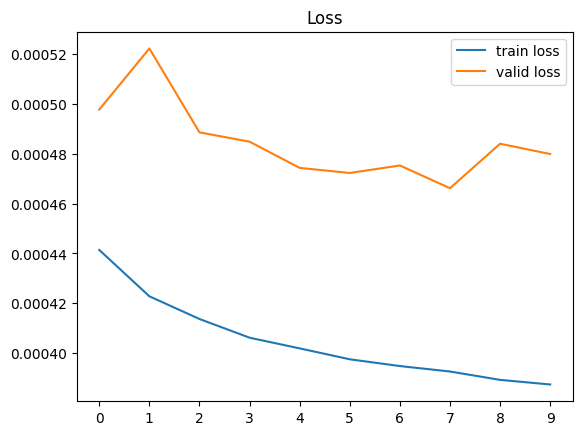

In [46]:
print(f'train loss: {train_losses}')
print(f'valid loss: {valid_losses}')
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(range(len(train_losses)))
plt.legend()
plt.title('Loss')
plt.show()

train error margin: [16.649520874023438, 16.186004638671875, 16.145933151245117, 15.9940185546875, 15.990429878234863, 15.267343521118164, 15.216506958007812, 15.394736289978027, 15.00837230682373, 14.988636016845703]
valid error margin: [26.26315689086914, 27.052631378173828, 26.636362075805664, 23.765548706054688, 22.186601638793945, 23.296649932861328, 22.789472579956055, 22.06220054626465, 23.569377899169922, 23.349281311035156]


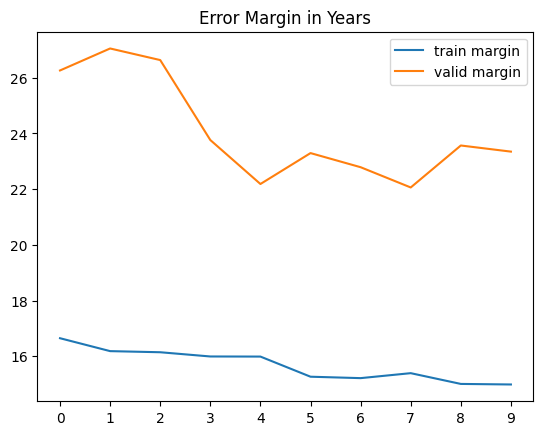

In [47]:
print(f'train error margin: {train_errors}')
print(f'valid error margin: {valid_errors}')
plt.plot(train_errors, label='train margin')
plt.plot(valid_errors, label='valid margin')
plt.xticks(range(len(train_errors)))
plt.legend()
plt.title('Error Margin in Years')
plt.show()

correct: 76
argmax: 57


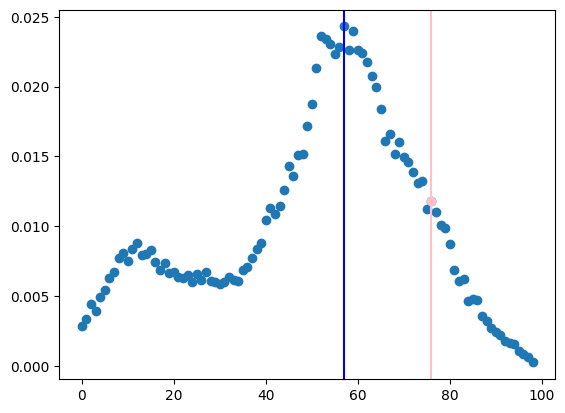

correct: 47
argmax: 59


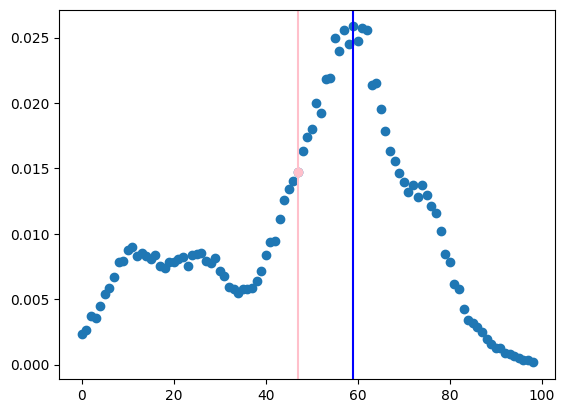

correct: 28
argmax: 65


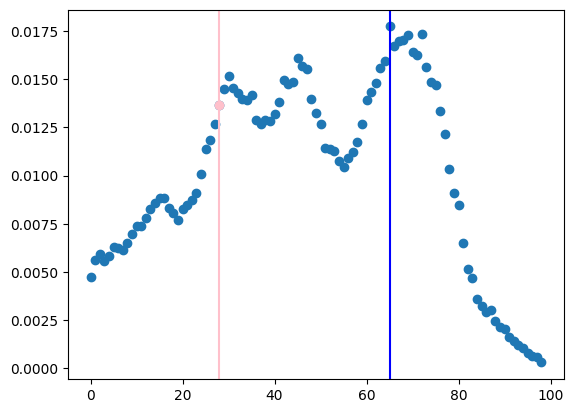

correct: 16
argmax: 15


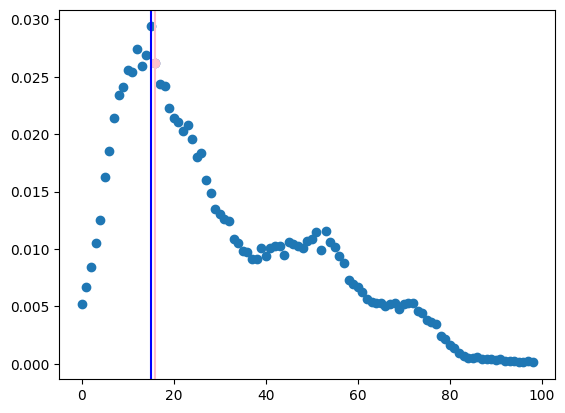

correct: 24
argmax: 23


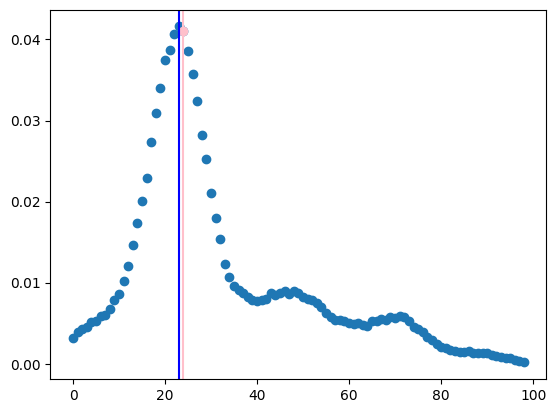

correct: 5
argmax: 91


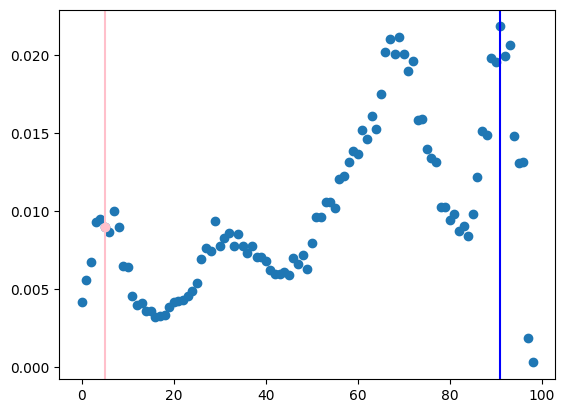

correct: 68
argmax: 66


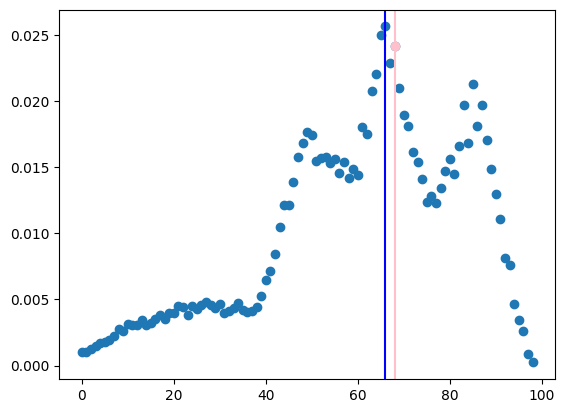

correct: 21
argmax: 21


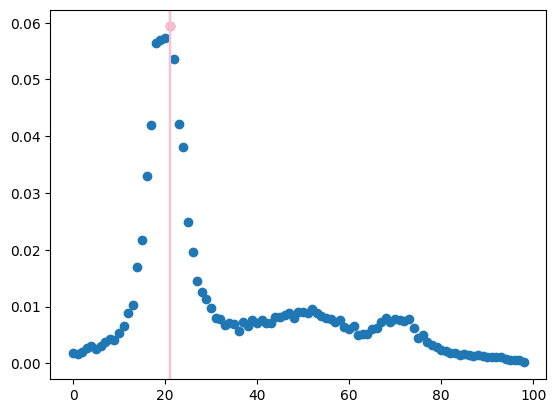

correct: 61
argmax: 61


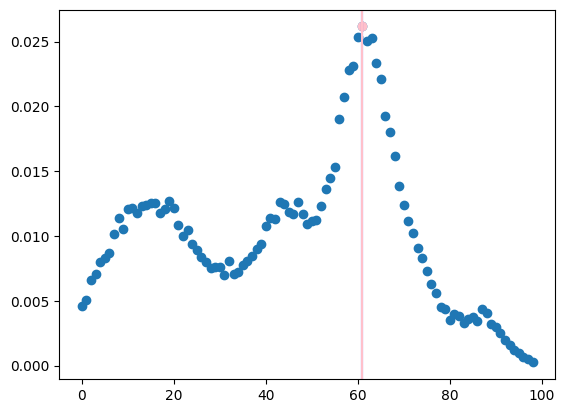

correct: 2
argmax: 30


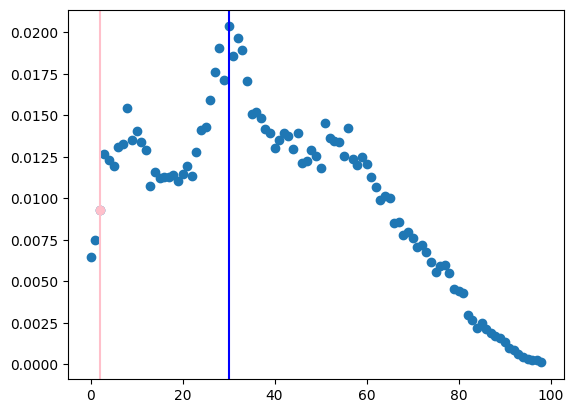

In [48]:
# Just get one random batch from the dataloader
# for item in test_dataloader:
for item in train_dataloader:
  # print(item)
  text, year, mask = item
  break

pred = model(text, mask)
# print(year)
# print(pred)
# print(year.shape)
# print(pred.shape)

for inputs, values in zip(year, pred):
  correct = torch.argmax(inputs).item()
  correct_guess_val = values.tolist()[correct]
  guess = torch.argmax(values).item()
  guess_val = values.tolist()[guess]
  print(f'correct: {correct}')
  print(f'argmax: {guess}')

  X = torch.arange(GLOBAL_YEAR_RANGE).tolist()
  plt.scatter(X, values.tolist())
  plt.axvline(x=guess, color='blue')
  plt.axvline(x=correct, color='pink')
  plt.scatter(correct, correct_guess_val, color='pink')
  # plt.scatter(X, inputs.tolist(), color='orange')
  plt.show()


## Continuous Prediction Model

In [49]:
continuous_model = ContinuousModel(distilbert_continuous).to(device)
continuous_model.apply(init_classification_head_weights)
continuous_model.to(device)
print(f'Total trainable params: {count_params(continuous_model):,}')
print(f'          Total params: {total_params(continuous_model):,}')
print('Continuous model initialized\n')

Total trainable params: 769
          Total params: 66,363,649
Continuous model initialized



In [50]:
BATCH_SIZE = 16
LR = 1e-3
N_EPOCHS = 25
CLIP = 1.0

In [51]:
train_dataloader = DataLoader(
  train_dataset,
  batch_size=BATCH_SIZE,
  collate_fn=partial(continuous_collate, tokenizer=distil_tokenizer),
  shuffle=False
)
val_dataloader = DataLoader(
  val_dataset,
  batch_size=BATCH_SIZE,
  collate_fn=partial(continuous_collate, tokenizer=distil_tokenizer)
)
test_dataloader = DataLoader(
  test_dataset,
  batch_size=BATCH_SIZE,
  collate_fn=partial(continuous_collate, tokenizer=distil_tokenizer)
)

optimizer = optim.Adam(continuous_model.parameters(), lr=LR)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=N_EPOCHS*len(train_dataloader))
continuous_criterion = torch.nn.MSELoss()

In [52]:
print(f'The model has {count_params(continuous_model):,} trainable parameters')
print(f'Total num of params: {total_params(continuous_model):,}')

The model has 769 trainable parameters
Total num of params: 66,363,649


In [53]:
train_loss = evaluate(continuous_model, train_dataloader, continuous_criterion, device)
train_error = continuous_dist(continuous_model, train_dataloader, device)
# train_acc = continuous_acc(continuous_model, train_dataloader, device)

valid_loss = evaluate(continuous_model, val_dataloader, continuous_criterion, device)
valid_error = continuous_dist(continuous_model, val_dataloader, device)
# valid_acc = continuous_acc(continuous_model, val_dataloader, device)

print(f'Initial Train Loss: {train_loss:.5f}')
print(f'Initial Train Error Margin (years): {train_error:.3f}')
# print(f'Initial Train Acc: {train_acc:.3f}')
print(f'Initial Valid Loss: {valid_loss:.5f}')
print(f'Initial Valid Error Margin (years): {valid_error:.3f}')
# print(f'Initial Valid Acc: {valid_acc:.3f}')

train_losses = []
train_accs = []
train_errors = []
valid_losses = []
valid_accs = []
valid_errors = []
for epoch in range(N_EPOCHS):
  start_time = time.time()
  train_loss = train(continuous_model, train_dataloader, optimizer, continuous_criterion, device, CLIP, scheduler)
  end_time = time.time()
  train_error = continuous_dist(continuous_model, train_dataloader, device)
  # train_acc = continuous_acc(continuous_model, train_dataloader, device)

  valid_loss = evaluate(continuous_model, val_dataloader, continuous_criterion, device)
  valid_error = continuous_dist(continuous_model, val_dataloader, device)
  # valid_acc = continuous_acc(continuous_model, val_dataloader, device)

  train_losses.append(train_loss)
  train_errors.append(train_error.item())
  # train_accs.append(train_acc.item())
  valid_losses.append(valid_loss)
  valid_errors.append(valid_error.item())
  # valid_accs.append(valid_acc.item())

  epoch_secs = end_time - start_time

  print(f'Epoch: {epoch+1:02}  / {N_EPOCHS}| Time: {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.5f}')
  print(f'\tTrain Error Margin: {train_error:.3f}')
  # print(f'\tTrain Acc: {train_acc:.3f}')
  print(f'\tValid Loss: {valid_loss:.5f}')
  print(f'\tValid Error Margin: {valid_error:.3f}')
  # print(f'\tValid Acc: {valid_acc:.3f}')

test_loss = evaluate(continuous_model, test_dataloader, continuous_criterion, device)
# test_acc = continuous_acc(continuous_model, test_dataloader, device)
test_error = continuous_dist(continuous_model, test_dataloader, device).item()
print(f'TESTING:')
print(f'\t      Testing Loss: {test_loss:.5f}')
# print(f'\t  Testing Accuracy: {test_acc:.3f}')
print(f'\tTesting Err Margin: {test_error:.3f}')

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Initial Train Loss: 0.17894
Initial Train Error Margin (years): 35.399
Initial Valid Loss: 0.28564
Initial Valid Error Margin (years): 39.344


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 01  / 25| Time: 22.655990600585938s
	Train Loss: 0.06677
	Train Error Margin: 21.824
	Valid Loss: 0.10016
	Valid Error Margin: 24.943


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 02  / 25| Time: 23.16628336906433s
	Train Loss: 0.05034
	Train Error Margin: 22.339
	Valid Loss: 0.09975
	Valid Error Margin: 24.756


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 03  / 25| Time: 23.024039268493652s
	Train Loss: 0.04797
	Train Error Margin: 21.035
	Valid Loss: 0.09478
	Valid Error Margin: 24.249


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 04  / 25| Time: 23.049909830093384s
	Train Loss: 0.04630
	Train Error Margin: 22.901
	Valid Loss: 0.10244
	Valid Error Margin: 25.325


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 05  / 25| Time: 23.001198053359985s
	Train Loss: 0.04594
	Train Error Margin: 21.910
	Valid Loss: 0.09854
	Valid Error Margin: 24.809


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 06  / 25| Time: 22.95559549331665s
	Train Loss: 0.04484
	Train Error Margin: 19.178
	Valid Loss: 0.08943
	Valid Error Margin: 23.847


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 07  / 25| Time: 22.969202518463135s
	Train Loss: 0.04214
	Train Error Margin: 18.599
	Valid Loss: 0.08311
	Valid Error Margin: 23.167


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 08  / 25| Time: 23.00796604156494s
	Train Loss: 0.04270
	Train Error Margin: 19.185
	Valid Loss: 0.08543
	Valid Error Margin: 23.282


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 09  / 25| Time: 23.030274629592896s
	Train Loss: 0.04307
	Train Error Margin: 19.002
	Valid Loss: 0.08735
	Valid Error Margin: 23.665


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10  / 25| Time: 23.02630352973938s
	Train Loss: 0.04286
	Train Error Margin: 18.273
	Valid Loss: 0.08529
	Valid Error Margin: 23.694


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11  / 25| Time: 23.081655979156494s
	Train Loss: 0.04201
	Train Error Margin: 18.151
	Valid Loss: 0.08242
	Valid Error Margin: 23.311


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12  / 25| Time: 22.992695093154907s
	Train Loss: 0.04216
	Train Error Margin: 16.696
	Valid Loss: 0.07691
	Valid Error Margin: 23.249


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 13  / 25| Time: 22.980769634246826s
	Train Loss: 0.04105
	Train Error Margin: 17.441
	Valid Loss: 0.08228
	Valid Error Margin: 23.641


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 14  / 25| Time: 23.0172221660614s
	Train Loss: 0.04154
	Train Error Margin: 16.085
	Valid Loss: 0.07793
	Valid Error Margin: 23.799


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 15  / 25| Time: 23.044827461242676s
	Train Loss: 0.03983
	Train Error Margin: 16.388
	Valid Loss: 0.07677
	Valid Error Margin: 23.402


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 16  / 25| Time: 23.04594612121582s
	Train Loss: 0.03874
	Train Error Margin: 16.728
	Valid Loss: 0.07830
	Valid Error Margin: 23.584


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 17  / 25| Time: 23.06488609313965s
	Train Loss: 0.03916
	Train Error Margin: 17.227
	Valid Loss: 0.08315
	Valid Error Margin: 24.019


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 18  / 25| Time: 23.045387983322144s
	Train Loss: 0.03986
	Train Error Margin: 15.984
	Valid Loss: 0.07758
	Valid Error Margin: 24.019


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 19  / 25| Time: 23.09258770942688s
	Train Loss: 0.03736
	Train Error Margin: 16.452
	Valid Loss: 0.08193
	Valid Error Margin: 24.469


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 20  / 25| Time: 23.098137378692627s
	Train Loss: 0.03893
	Train Error Margin: 16.266
	Valid Loss: 0.08105
	Valid Error Margin: 24.445


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 21  / 25| Time: 23.074734926223755s
	Train Loss: 0.03802
	Train Error Margin: 16.129
	Valid Loss: 0.08209
	Valid Error Margin: 24.746


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 22  / 25| Time: 23.05326819419861s
	Train Loss: 0.03718
	Train Error Margin: 15.766
	Valid Loss: 0.08101
	Valid Error Margin: 24.866


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 23  / 25| Time: 23.060117483139038s
	Train Loss: 0.03805
	Train Error Margin: 15.648
	Valid Loss: 0.08171
	Valid Error Margin: 25.172


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 24  / 25| Time: 23.08887219429016s
	Train Loss: 0.03764
	Train Error Margin: 15.067
	Valid Loss: 0.07975
	Valid Error Margin: 25.440


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 25  / 25| Time: 23.08445644378662s
	Train Loss: 0.03927
	Train Error Margin: 14.870
	Valid Loss: 0.08055
	Valid Error Margin: 26.258


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

TESTING:
	      Testing Loss: 0.14615
	Testing Err Margin: 32.273


train loss: [0.06676834122765632, 0.05033716827276207, 0.04796875188393252, 0.04630095157772303, 0.045937419620652994, 0.04484200678943168, 0.04213663493948323, 0.04270101824686641, 0.04307161346077919, 0.04286059304362252, 0.04200892704760745, 0.042155050300061704, 0.04105477183170262, 0.0415429122568596, 0.039833315364306884, 0.03874388367292427, 0.039159937539980524, 0.03985804791251819, 0.03735535202459211, 0.038926915939719905, 0.03801896238610858, 0.03718469071955908, 0.03804616282383601, 0.03764448549066271, 0.039267163519703205]
valid loss: [0.10016259870358876, 0.09974808245897293, 0.09478138147720269, 0.10244000463613442, 0.09854166874928134, 0.08943230525723525, 0.0831080749630928, 0.08542938424008233, 0.0873507232006107, 0.08529418520629406, 0.08241834784192699, 0.07690527024013656, 0.0822777436780078, 0.07792759553662368, 0.07676779798098973, 0.07829846202262811, 0.08315108929361616, 0.0775779155748231, 0.08192909056586879, 0.08105260798973697, 0.08208648088787283, 0.08101

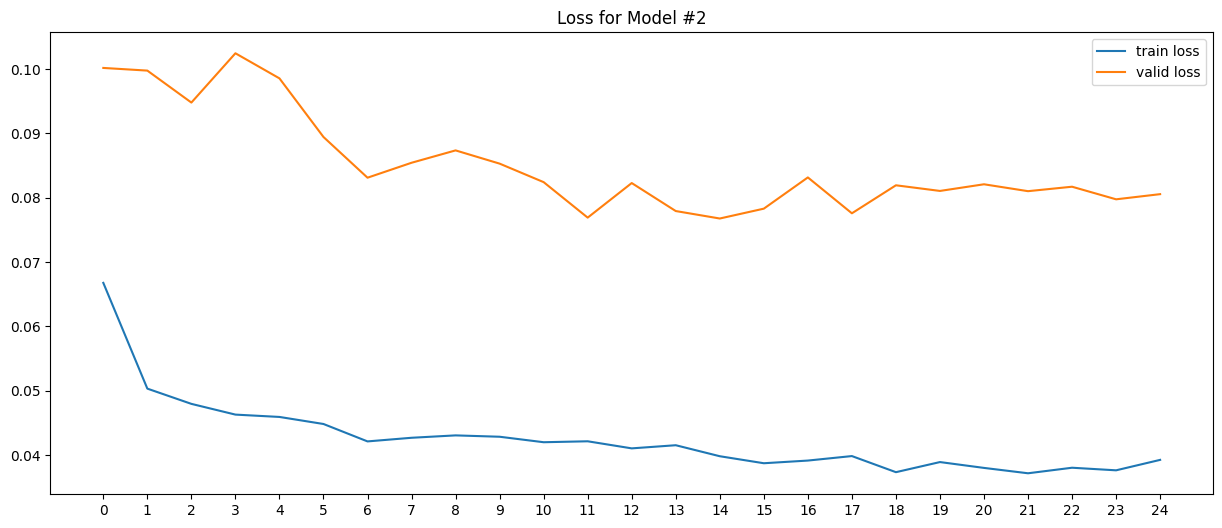

In [57]:
print(f'train loss: {train_losses}')
print(f'valid loss: {valid_losses}')
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(range(len(train_losses)))
plt.title('Loss for Model #2')
plt.legend()
plt.show()

train margins: [21.823564529418945, 22.339113235473633, 21.03468894958496, 22.901315689086914, 21.91028594970703, 19.1782283782959, 18.599281311035156, 19.1848087310791, 19.002391815185547, 18.273324966430664, 18.151315689086914, 16.695573806762695, 17.44078826904297, 16.084928512573242, 16.38815689086914, 16.72787094116211, 17.227272033691406, 15.983851432800293, 16.452152252197266, 16.26614761352539, 16.12858772277832, 15.765549659729004, 15.647727012634277, 15.066985130310059, 14.869616508483887]
valid errors: [24.942583084106445, 24.755979537963867, 24.248802185058594, 25.32535743713379, 24.808610916137695, 23.84688949584961, 23.167463302612305, 23.28229522705078, 23.665071487426758, 23.69377899169922, 23.311004638671875, 23.248802185058594, 23.64114761352539, 23.799041748046875, 23.401912689208984, 23.583730697631836, 24.01913833618164, 24.01913833618164, 24.46889877319336, 24.444974899291992, 24.746410369873047, 24.86602783203125, 25.1722469329834, 25.4401912689209, 26.2583713531

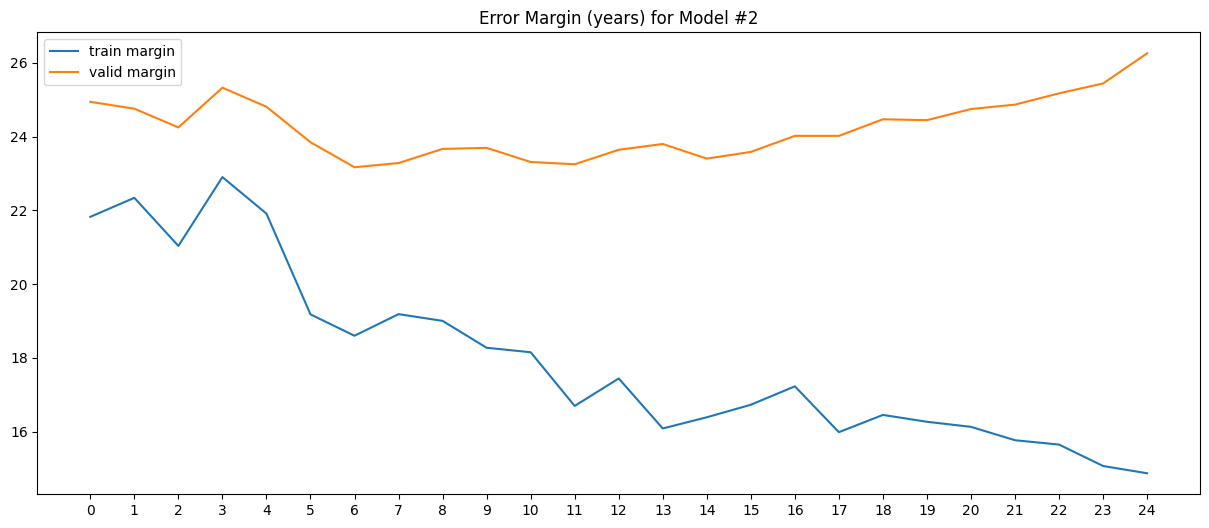

In [58]:
print(f'train margins: {train_errors}')
print(f'valid errors: {valid_errors}')
plt.figure(figsize=(15,6))
plt.plot(train_errors, label='train margin')
plt.plot(valid_errors, label='valid margin')
plt.xticks(range(len(train_losses)))
plt.title('Error Margin (years) for Model #2')
plt.legend()
plt.show()

In [59]:
for item in test_dataloader:
  text, normal_year, mask, real_year = item
  pred = continuous_model(text, mask)
  print(normal_year)
  print(pred)
  real_pred = (pred * GLOBAL_YEAR_RANGE) + GLOBAL_MIN_YEAR
  print(real_year)
  print(real_pred)
  break

tensor([[0.0909],
        [0.9394],
        [0.8384],
        [0.8384],
        [0.0808],
        [0.7980],
        [0.8081],
        [0.8384],
        [0.8384],
        [0.8586],
        [0.0808],
        [0.9091],
        [0.8384],
        [0.7980],
        [0.8889],
        [0.8384]], device='cuda:0')
tensor([[0.3355],
        [0.5345],
        [0.6820],
        [0.6521],
        [0.4220],
        [0.4893],
        [0.7072],
        [0.6164],
        [0.5855],
        [0.8129],
        [0.2428],
        [0.5030],
        [0.5720],
        [0.6129],
        [0.5706],
        [0.6360]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[1859.],
        [1943.],
        [1933.],
        [1933.],
        [1858.],
        [1929.],
        [1930.],
        [1933.],
        [1933.],
        [1935.],
        [1858.],
        [1940.],
        [1933.],
        [1929.],
        [1938.],
        [1933.]], device='cuda:0')
tensor([[1883.2115],
        [1902.9113],
        [1917.5160],
        [

## I-BERT Model

In [60]:
# ibert_model = DiscreteModel(ibert_submodel).to(device)
# ibert_model = DiscreteModel(ibert_submodel, flatten_all=True, n_layers=3).to(device)
ibert_model = DiscreteModel(ibert_submodel, dropout=0.2, flatten_all=False).to(device)
ibert_model.apply(init_classification_head_weights)
ibert_model.to(device)
print(f'Total trainable params: {count_params(ibert_model):,}')
print(f'          Total params: {total_params(ibert_model):,}')
print('IBert model initialized')

Total trainable params: 76,131
          Total params: 124,721,763
IBert model initialized


In [61]:
BATCH_SIZE = 10
LR = 1e-3
N_EPOCHS = 10
CLIP = 1.0

In [62]:
train_dataloader = DataLoader(
  train_dataset,
  batch_size=BATCH_SIZE,
  collate_fn=partial(discrete_collate, tokenizer=ibert_tokenizer),
  shuffle=False
)
val_dataloader = DataLoader(
  val_dataset,
  batch_size=BATCH_SIZE,
  collate_fn=partial(discrete_collate, tokenizer=ibert_tokenizer)
)
test_dataloader = DataLoader(
  test_dataset,
  batch_size=BATCH_SIZE,
  collate_fn=partial(discrete_collate, tokenizer=ibert_tokenizer)
)

optimizer = optim.Adam(ibert_model.parameters(), lr=LR)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=N_EPOCHS*len(train_dataloader))
continuous_criterion = torch.nn.MSELoss()

In [63]:
# Set model to fine-tune distil-bert
# for param in ibert_model.parameters():
#   param.requires_grad = True

print(f'The model has {count_params(ibert_model):,} trainable parameters')
print(f'Total num of params: {total_params(ibert_model):,}')
print(ibert_model.enc_hid_dim)
# print(ibert_model)

The model has 76,131 trainable parameters
Total num of params: 124,721,763
768


In [64]:
train_loss = evaluate(ibert_model, train_dataloader, continuous_criterion, device)
train_error = evaluate_dist(ibert_model, train_dataloader, device)

valid_loss = evaluate(ibert_model, val_dataloader, continuous_criterion, device)
valid_error = evaluate_dist(ibert_model, val_dataloader, device)

print(f'Initial Train Loss: {train_loss:.5f}')
print(f'Initial Train Error Margin (years): {train_error:.3f}')
print(f'Initial Valid Loss: {valid_loss:.5f}')
print(f'Initial Valid Error Margin (years): {valid_error:.3f}')

train_losses = []
train_errors = []
valid_losses = []
valid_errors = []
for epoch in range(N_EPOCHS):
  start_time = time.time()
  train_loss = train(ibert_model, train_dataloader, optimizer, continuous_criterion, device, CLIP, scheduler)
  end_time = time.time()
  train_error = evaluate_dist(ibert_model, train_dataloader, device)

  valid_loss = evaluate(ibert_model, val_dataloader, continuous_criterion, device)
  valid_error = evaluate_dist(ibert_model, val_dataloader, device)

  train_losses.append(train_loss)
  train_errors.append(train_error.item())
  valid_losses.append(valid_loss)
  valid_errors.append(valid_error.item())

  epoch_secs = end_time - start_time

  print(f'Epoch: {epoch+1:02} / {N_EPOCHS:02} | Time: {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.5f}')
  print(f'\tTrain Error Margin: {train_error:.3f}')
  print(f'\tValid Loss: {valid_loss:.5f}')
  print(f'\tValid Error Margin: {valid_error:.3f}')

test_loss = evaluate(ibert_model, test_dataloader, continuous_criterion, device)
test_error = evaluate_dist(ibert_model, test_dataloader, device)
print(f'TESTING:')
print(f'\tTesting Loss: {test_loss:.5f}')
print(f'\tTesting Error Margin: {test_error:.3f}')

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Initial Train Loss: 0.00047
Initial Train Error Margin (years): 37.177
Initial Valid Loss: 0.00047
Initial Valid Error Margin (years): 42.038


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 01 / 10 | Time: 56.411447048187256s
	Train Loss: 0.00045
	Train Error Margin: 32.944
	Valid Loss: 0.00047
	Valid Error Margin: 38.469


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 02 / 10 | Time: 56.42842936515808s
	Train Loss: 0.00045
	Train Error Margin: 29.523
	Valid Loss: 0.00046
	Valid Error Margin: 36.569


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 03 / 10 | Time: 56.46572709083557s
	Train Loss: 0.00044
	Train Error Margin: 21.418
	Valid Loss: 0.00047
	Valid Error Margin: 34.464


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 04 / 10 | Time: 56.37988471984863s
	Train Loss: 0.00044
	Train Error Margin: 22.402
	Valid Loss: 0.00047
	Valid Error Margin: 35.010


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 05 / 10 | Time: 56.381306409835815s
	Train Loss: 0.00044
	Train Error Margin: 20.553
	Valid Loss: 0.00047
	Valid Error Margin: 35.330


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 06 / 10 | Time: 56.528419733047485s
	Train Loss: 0.00044
	Train Error Margin: 19.025
	Valid Loss: 0.00048
	Valid Error Margin: 33.148


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 07 / 10 | Time: 56.44230794906616s
	Train Loss: 0.00044
	Train Error Margin: 18.858
	Valid Loss: 0.00048
	Valid Error Margin: 33.737


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 08 / 10 | Time: 56.373910427093506s
	Train Loss: 0.00044
	Train Error Margin: 18.643
	Valid Loss: 0.00049
	Valid Error Margin: 33.440


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 09 / 10 | Time: 56.409791231155396s
	Train Loss: 0.00044
	Train Error Margin: 18.815
	Valid Loss: 0.00050
	Valid Error Margin: 33.383


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10 / 10 | Time: 56.51579165458679s
	Train Loss: 0.00043
	Train Error Margin: 18.766
	Valid Loss: 0.00050
	Valid Error Margin: 32.818


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

TESTING:
	Testing Loss: 0.00054
	Testing Error Margin: 37.608


train loss: [0.0004488987937552987, 0.0004499630908650856, 0.0004445306305050118, 0.0004400197940412909, 0.00043959645803884735, 0.00043944393421822624, 0.00043736541175305667, 0.00043688581700691777, 0.00043517763766604255, 0.0004332087489837293]
valid loss: [0.0004693809051310555, 0.00046324402986404795, 0.00047212109313390796, 0.00046958397087153224, 0.0004714421063129391, 0.00047940256384511787, 0.0004847893932102514, 0.0004890521827508651, 0.0004962686064010043, 0.0004980776159624968]


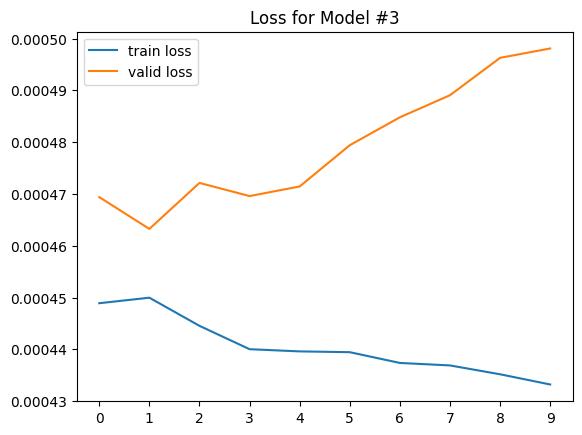

In [68]:
print(f'train loss: {train_losses}')
print(f'valid loss: {valid_losses}')
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(range(len(train_losses)))
plt.title('Loss for Model #3')
plt.legend()
plt.show()

train margin: [32.94377899169922, 29.523324966430664, 21.418062210083008, 22.401912689208984, 20.552631378173828, 19.024520874023438, 18.858253479003906, 18.642942428588867, 18.8151912689209, 18.765548706054688]
valid margin: [38.46889877319336, 36.56937789916992, 34.464115142822266, 35.00956726074219, 35.330142974853516, 33.14832305908203, 33.736839294433594, 33.440189361572266, 33.382774353027344, 32.818180084228516]


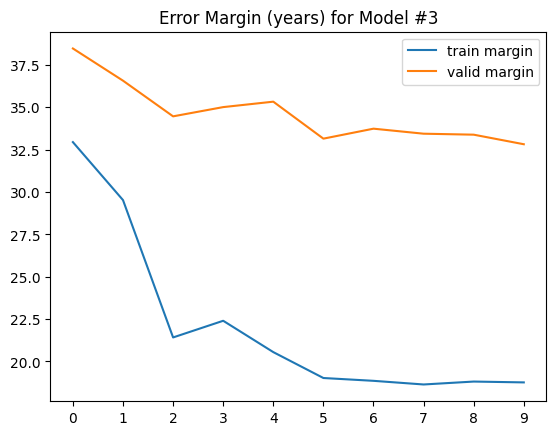

In [69]:
print(f'train margin: {train_errors}')
print(f'valid margin: {valid_errors}')
plt.plot(train_errors, label='train margin')
plt.plot(valid_errors, label='valid margin')
plt.xticks(range(len(train_losses)))
plt.title('Error Margin (years) for Model #3')
plt.legend()
plt.show()

correct: 9
argmax: 32


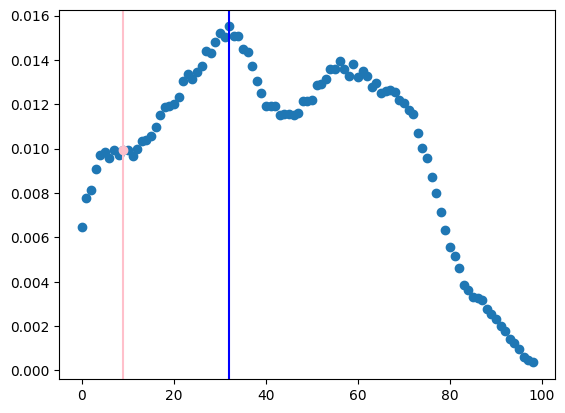

correct: 93
argmax: 56


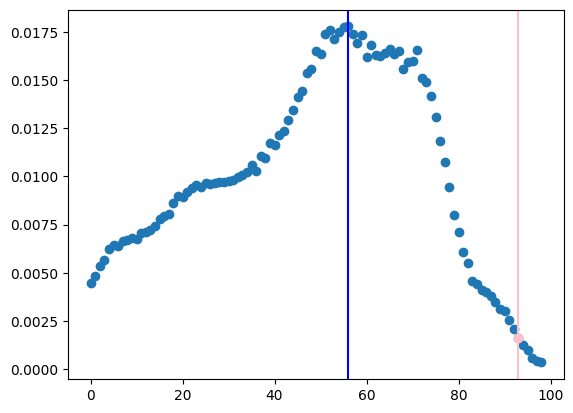

correct: 83
argmax: 71


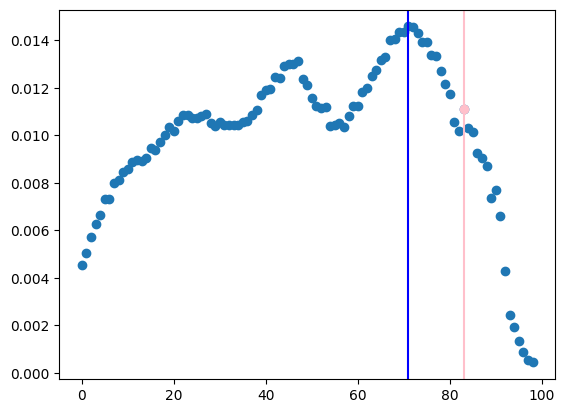

correct: 83
argmax: 44


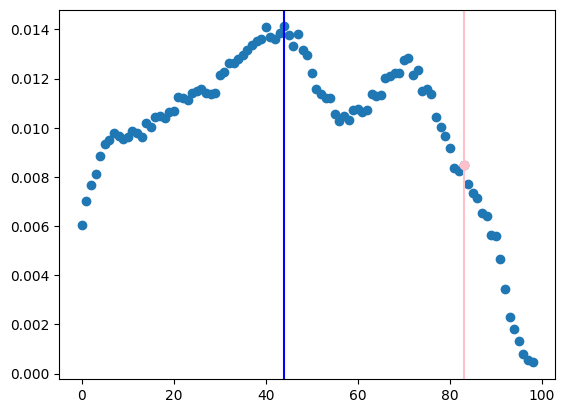

correct: 8
argmax: 34


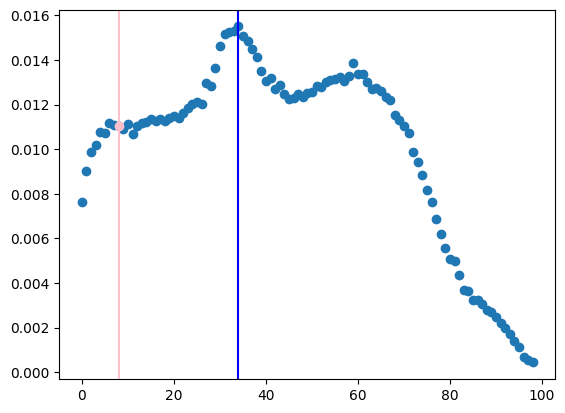

correct: 79
argmax: 57


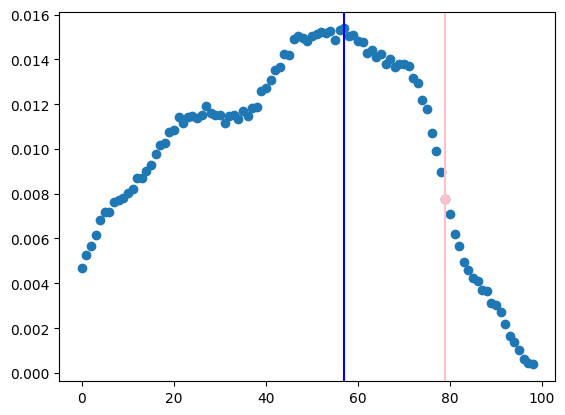

correct: 80
argmax: 70


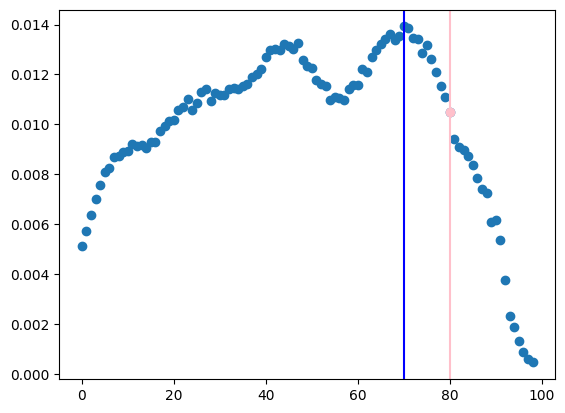

correct: 83
argmax: 70


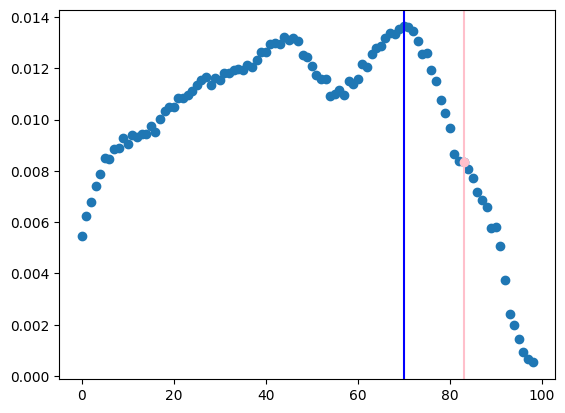

correct: 83
argmax: 71


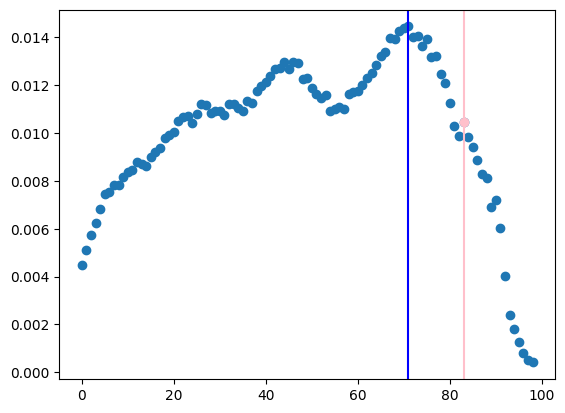

correct: 85
argmax: 71


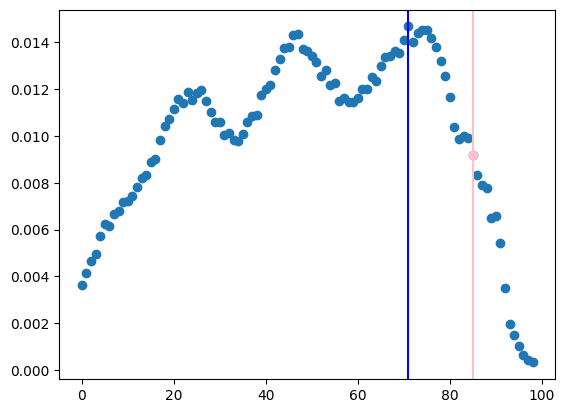

In [67]:
# Just get one random batch from the dataloader
for item in test_dataloader:
  text, year, mask = item
  break

pred = ibert_model(text, mask)
for inputs, values in zip(year, pred):
  correct = torch.argmax(inputs).item()
  correct_guess_val = values.tolist()[correct]
  guess = torch.argmax(values).item()
  guess_val = values.tolist()[guess]
  print(f'correct: {correct}')
  print(f'argmax: {guess}')

  X = torch.arange(GLOBAL_YEAR_RANGE).tolist()
  plt.scatter(X, values.tolist())
  plt.axvline(x=guess, color='blue')
  plt.axvline(x=correct, color='pink')
  plt.scatter(correct, correct_guess_val, color='pink')
  plt.show()
